# Introdução

Este exercício consiste em utilizar o método de Análise de Componentes Principais (PCA) e de uma Máquina de Vetores de Suporte (SVM) para realizar a classificação do conjunto de dados Breast Cancer do repositório UCI[1]. 

# Base Breast Cancer Wisconsin (Original)

Este banco de dados de câncer de mama foi obtido dos Hospitais da Universidade de Wisconsin, em Madison, do Dr. William H. Wolberg.

Basicamente, o arquivo contendo os dados contém 1 coluna de Id (apenas um identificador) seguida de 9 colunas contendo os vetores de entrada x, e por fim, uma última coluna contendo a classificação do tumor, correspondente ao rótulo y daquela amostra. Este conjunto de dados contém 699 amostras. A tabela abaixo mostra a organização do conjunto de dados.



          Attribute                     Domain
   -- -----------------------------------------
       1. Sample code number            id number
       2. Clump Thickness               1 - 10
       3. Uniformity of Cell Size       1 - 10
       4. Uniformity of Cell Shape      1 - 10
       5. Marginal Adhesion             1 - 10
       6. Single Epithelial Cell Size   1 - 10
       7. Bare Nuclei                   1 - 10
       8. Bland Chromatin               1 - 10
       9. Normal Nucleoli               1 - 10
      10. Mitoses                       1 - 10
      11. Class:                        benign or malignant
      

# Carregando Dataset

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from numpy.random import RandomState
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

In [61]:
df = pd.read_csv("~/Documents/UFMG/10/Reconhecimento de padrões/list/pattern-recognition-exercises/list_11/databases/BreastCancer.csv")
print(df.shape)
df.head(5)

(699, 11)


,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,benign
1,1002945,5,4,4,5,7,10.0,3,2,1,benign
2,1015425,3,1,1,1,2,2.0,3,1,1,benign
3,1016277,6,8,8,1,3,4.0,3,7,1,benign
4,1017023,4,1,1,3,2,1.0,3,1,1,benign


# Pré-processamento

In [62]:
df=df.dropna()
print(df.shape)
mapping = {'benign': 1, 'malignant': 0}
df = df.replace({"Class": mapping})
del df['Id']
df.sample(4)

(683, 11)


,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
53,5,5,5,8,10,8.0,7,3,7,0
134,3,1,1,1,3,1.0,2,1,1,1
326,10,1,1,1,2,10.0,5,4,1,0
572,3,1,1,1,2,1.0,2,1,1,1


# Redução de Dimensionalidade - PCA

Inicialmente, apenas para verificar a função PCA do pacote sklearn, a mesma será aplicada ao dataset para gerar dados com apenas 3 features. Ou seja reduziu-se de 9 features para apenas 3. 

In [63]:
df = df.to_numpy()
pca = PCA(n_components=3)
pca.fit(df[:,0:-1])
X = pca.transform(df[:,0:-1])
print(X.shape)

(683, 3)


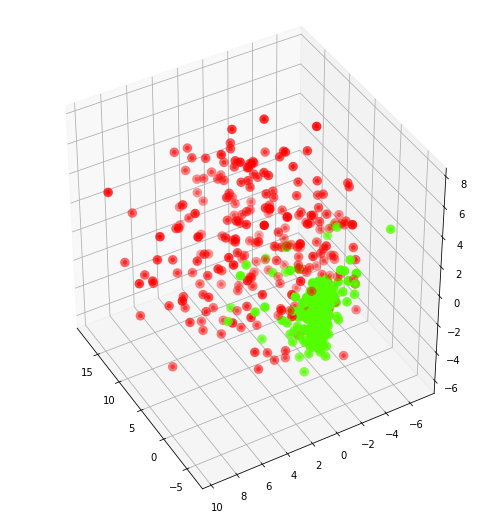

In [77]:
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=38,azim=150)
plt.cla()

y = df[:,-1]
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.prism, linewidths=5)
plt.show()

## Grafico de Variancias por PCs

Text(0.5, 1.0, 'Explained Variance vs PC')

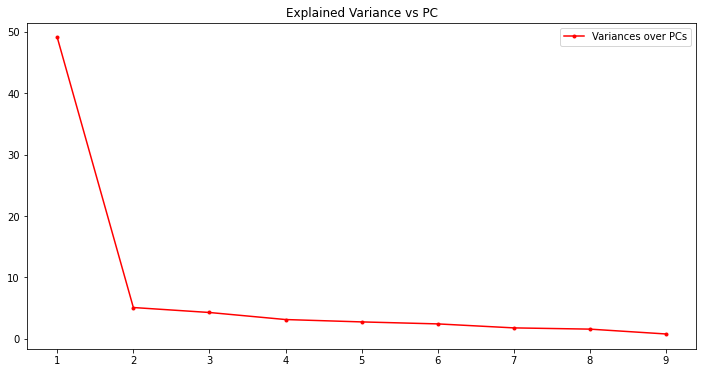

In [79]:
pca = PCA(n_components=9)
pca.fit(df[:,0:-1])
X = pca.transform(df[:,0:-1])
explained_variance = pca.explained_variance_

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.linspace(1,9,9), explained_variance,'r', marker='.', label="Variances over PCs")
ax.legend()
ax.set_title('Explained Variance vs PC')

In [80]:
explained_variance

array([49.04736573,  5.11071961,  4.3015747 ,  3.15520074,  2.77056914,
        2.44623225,  1.79671043,  1.59571469,  0.8068011 ])

# Seleção de Parâmetros do Modelo SVM

Agora deseja-se utilizar as variáveis do novo espaço projetado como a entrada de uma SVM de base radial  para realizar a classificação dos dados. Para seleção do parâmetro C do modelo SVM vai ser utilizado a função GridSearchCV (utilizando *10-fold cross validation*). Além disso, para essa seleção será considerado um modelo utilizando todos os 9 PCs.

In [86]:
parameters = {'C':range(1, 15)}
y = df[:,-1]
svc = svm.SVC(kernel="rbf", gamma='scale')
clf = GridSearchCV(svc, parameters, scoring='accuracy', refit=True, cv=10)  #To see results for each C just add: verbose=3
# Run fit with all sets of parameters.
clf.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'C': range(1, 15)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [87]:
C = clf.best_params_
score = clf.best_score_
print("The best accuracy average was " + str(score) + " and was achieved for " + str(C) )

The best accuracy average was 0.9692532942898975 and was achieved for {'C': 1}


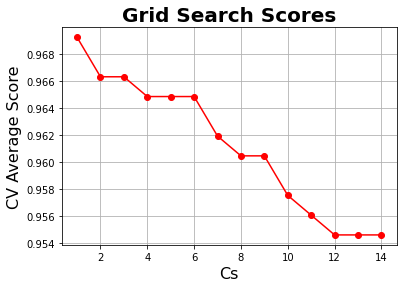

In [89]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    ax.plot(grid_param_1, scores_mean[:], '-o', color="red")

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

# Calling Method 
Cs = np.arange(1,15)
plot_grid_search(clf.cv_results_, Cs, 'Cs')

# Aplicação do PCA e do Classificador SVM

In [95]:
acc = np.zeros(10)
    
for n_features in range(1,10):
    for i in range(10):
        # Separate data between training and test:
        X_train, X_test, y_train, y_test = train_test_split(df[:, 0:-1], df[:, -1], test_size=0.3)
        pca = PCA(n_components=n_features)
        pca.fit(X_train)
        PCs = pca.transform(X_train)
        clf = svm.SVC(kernel="rbf", gamma='scale')
        clf.fit(PCs[:, 0:n_features], y_train)
        X = pca.transform(X_test)
        y_pred = clf.predict(X[:, 0:n_features])
        acc[i] = accuracy_score(y_test, y_pred)
    print("\nAcurácia média para modelo considerando " + str(n_features) + " features: " + '{:.3f}'.format(acc.mean()) + " +/- " + '{:.3f}'.format(acc.std()))   


Acurácia média para modelo considerando 1 features: 0.978 +/- 0.005

Acurácia média para modelo considerando 2 features: 0.967 +/- 0.013

Acurácia média para modelo considerando 3 features: 0.969 +/- 0.009

Acurácia média para modelo considerando 4 features: 0.970 +/- 0.012

Acurácia média para modelo considerando 5 features: 0.962 +/- 0.011

Acurácia média para modelo considerando 6 features: 0.973 +/- 0.007

Acurácia média para modelo considerando 7 features: 0.969 +/- 0.010

Acurácia média para modelo considerando 8 features: 0.968 +/- 0.007

Acurácia média para modelo considerando 9 features: 0.968 +/- 0.006


# Matriz de Confusão

Abaixo está mostrada a matriz de confusão para a aplicação do classificador ao problema considerando 1 feature. Esse valor foi escolhido pois como visto anteriormente ele resultou em uma maior acurácia, próxima a 98%.


Acc: 0.975609756097561


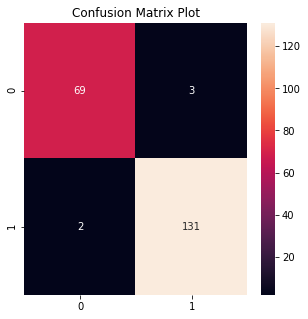

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df[:, 0:-1], df[:, -1], test_size=0.3)
n_features = 1
pca = PCA(n_components=n_features)
pca.fit(X_train)
PCs = pca.transform(X_train)
clf = svm.SVC(kernel="rbf", gamma='scale')
clf.fit(PCs[:, 0:n_features], y_train)
X = pca.transform(X_test)
y_pred = clf.predict(X[:, 0:n_features])
df_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
sns.heatmap(df_confusion, annot=True, ax=ax, fmt='g')
plt.title('Confusion Matrix Plot')
    
#plot_confusion_matrix(df_confusion)
print("\nAcc: " + str(accuracy_score(y_test,y_pred)))

# Referências

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 
